In [ ]:
!/usr/local/cuda/bin/nvcc —version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin
!cuda-install-samples-11.2.sh ~ & cd /root/NVIDIA_CUDA-11.2_samples/

nvcc fatal   : Don't know what to do with '—version'
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-xzw24hsl
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-xzw24hsl
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0a71d56e5dce3ff1f0dd2c47c29367629262f527
  Preparing metadata (setup.py) ... done
The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin
/bin/bash: line 1: cd: /root/NVIDIA_CUDA-11.2_samples/: No such file or directory
/bin/bash: line 1: cuda-install-samples-11.2.sh: command not found


In [ ]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <curand.h>
#include <curand_kernel.h>
#include <stdint.h>
#include <map>
#include <stdio.h>
#include <iostream>
#include <random>

__global__ void setup_kernel(curandState* state, uint64_t seed)
{
    int tid = threadIdx.x + blockIdx.x * blockDim.x;
    curand_init(seed, tid, 0, &state[tid]);
}

//Kernel function on GPU
__global__ void pi_calculate(curandState* state, int* count, int n) {
    extern __shared__ int shared[];
    int tx = threadIdx.x;
    int bx = blockIdx.x;
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    shared[tx] = 0;
    __syncthreads();

    unsigned int temp = 0;
    while (temp < n) {

        float x = curand_uniform(&state[idx]);
        float y = curand_uniform(&state[idx]);
        float r = x * x + y * y;

        if (r <= 1) {
            shared[tx]++;
        }
        temp++;
    }

    //reduction
    int index = 0;
    index = blockDim.x / 2;
    while (index != 0) {
        if (tx < index) {
            shared[tx] += shared[tx + index];
        }
        index /= 2;
        __syncthreads();
    }

    if (tx == 0) count[bx] = shared[0];
}


int main()
{
    for(int N = 1000; N <= 21000; N += 2000){
    //Задаём параметры грида
    printf("Количество точек N := %d\n", N);
    int pi_size = 256;
    int dimBlock = 128;
    int dimGrid = int(N/dimBlock);
    int m = dimBlock*dimGrid;
    printf("GridDim := %d", dimGrid);
    printf("\nBlockDim := %d\n", dimBlock);
    int n2b = m * sizeof(int);

    unsigned int reduce = 0;

    int* h_pi = (int*)malloc(m * sizeof(int));

    curandState* d_state;
    float pi_gpu;



    // Выделение памяти на устройстве
    int* d_pi;
    cudaError_t cuerr = cudaMalloc((void**)&d_pi, n2b);
    if (cuerr != cudaSuccess)
    {
        fprintf(stderr, "Cannot malloc device: %s\n",
            cudaGetErrorString(cuerr));
        return 0;
    }
    cudaMemset(d_pi, 0, sizeof(int));
    if (cuerr != cudaSuccess)
    {
        fprintf(stderr, "Cannot memset device: %s\n",
            cudaGetErrorString(cuerr));
        return 0;
    }
    cudaMalloc((void**)&d_state, m * sizeof(curandState));
    if (cuerr != cudaSuccess)
    {
        fprintf(stderr, "Cannot malloc curandState device: %s\n",
            cudaGetErrorString(cuerr));
        return 0;
    }

    // Создание обработчиков событий
    cudaEvent_t start, stop;
    float gpuTime = 0.0;
    cuerr = cudaEventCreate(&start);
    cuerr = cudaEventCreate(&stop);


    // Установка точки старта
    cuerr = cudaEventRecord(start, 0);
    //Запуск ядра
    setup_kernel <<< dimGrid, dimBlock >>> (d_state, time(NULL));
    pi_calculate <<< dimGrid, dimBlock, dimBlock * sizeof(int) >>> (d_state, d_pi, N);
    // Синхронизация устройств
    cuerr = cudaDeviceSynchronize();
    if (cuerr != cudaSuccess)
    {
        fprintf(stderr, "Cannot cudaDeviceSynchronize: %s\n",
            cudaGetErrorString(cuerr));
        return 0;
    }
    // Копирование результата на хост
    cuerr = cudaMemcpy(h_pi, d_pi, n2b, cudaMemcpyDeviceToHost);
    if (cuerr != cudaSuccess)
    {
        fprintf(stderr, "Cannot copy c array from device to host: %s\n",
            cudaGetErrorString(cuerr));
        return 0;
    }

    // Накапливаем результат редукции в блоках в одну ячейку
    for (int i = 0; i < dimGrid; i++) {
        reduce += h_pi[i];
    }
    pi_gpu = reduce * 4.0 / (N * m);


    // Расчет времени
    // Количество нитей меньше количества элементов
    // Установка точки окончания
    cuerr = cudaEventRecord(stop, 0);
    cuerr = cudaEventSynchronize(stop);
    cuerr = cudaEventElapsedTime(&gpuTime, start, stop);
    cudaEventDestroy(start);
    cudaEventDestroy(stop);


    printf("The GPU calculated for %s: %.9f seconds\n", "kernel", gpuTime / 1000);
    printf("\nPI value on GPU := %.9f\n", pi_gpu);

    //  serial verion
	  std::default_random_engine generator;
	  std::uniform_real_distribution<float> distribution(0, 1.0);
	  int count = 0;

    clock_t cpu_start = clock();
    for(int i = 0; i < m; i++){
      int temp = 0;
      while(temp <= N){
	  	float x = distribution(generator);
			float y = distribution(generator);

	  	if((x*x + y*y) <= 1){
	  		count++;
	  	}
	  	temp++;
      }
    }

    float pi_cpu = 4.0*count/(N*m);
	  clock_t cpu_end = clock();
    float CPU_time = ((double)cpu_end - cpu_start) / ((double)CLOCKS_PER_SEC);
	  printf("\nThe CPU calculated for %.9f seconds\n", CPU_time);
    printf("\nPI value on СPU := %.9f\n", pi_cpu);

    printf("\nAcceleration on GPU := %.9f\n", CPU_time / (gpuTime / 1000));
    printf("\n=======================================\n");


    //Free GPU memory
    cudaFree(d_state);
    cudaFree(d_pi);

    // Free CPU memory
    free(h_pi);

    }
    return 0;
}

Количество точек N := 1000
GridDim := 7
BlockDim := 128
The GPU calculated for kernel: 0.000376096 seconds

PI value on GPU := 3.141236544

The CPU calculated for 0.078690000 seconds

PI value on СPU := 3.145973206

Acceleration on GPU := 209.228485107

Количество точек N := 3000
GridDim := 23
BlockDim := 128
The GPU calculated for kernel: 0.000644992 seconds

PI value on GPU := 3.142582893

The CPU calculated for 0.746179998 seconds

PI value on СPU := 3.142751694

Acceleration on GPU := 1156.882568359

Количество точек N := 5000
GridDim := 39
BlockDim := 128
The GPU calculated for kernel: 0.000927200 seconds

PI value on GPU := 3.141906738

The CPU calculated for 2.141530991 seconds

PI value on СPU := 3.141750813

Acceleration on GPU := 2309.675292969

Количество точек N := 7000
GridDim := 54
BlockDim := 128
The GPU calculated for kernel: 0.001471904 seconds

PI value on GPU := 3.140974998

The CPU calculated for 4.419769764 seconds

PI value on СPU := 3.141728878

Acceleration on G

# **Таблица с полученными результатами**

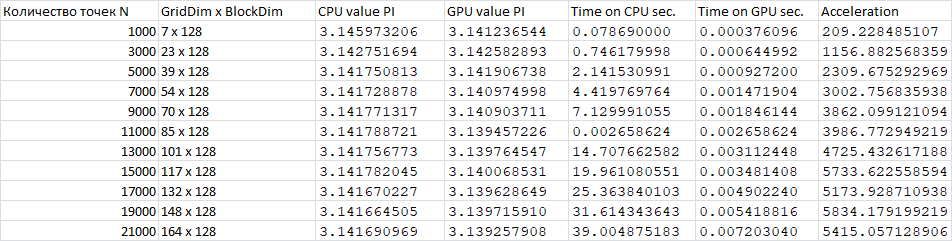